# **Setting up google drive**

In [ ]:
# Setting up google drive 
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
import sys
# sys.path.append('/content/gdrive/MyDrive/Colab Notebooks')
sys.path.append('/content/gdrive/MyDrive')

Mounted at /content/gdrive


In [ ]:
import my_utils as mu
import torch
from torch import nn 
from torch.utils import data
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F


# **1. Read dataset and create dataloaders**

In [ ]:
###https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
##https://github.com/kuangliu/pytorch-cifar/blob/master/main.py
import torchvision.transforms as transforms
import torchvision 
transform=transforms.Compose([transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))])

In [ ]:
batch_size=256
#read dataset train part
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,transform=transform,download=True)
#create dataloader train part
train_iter = data.DataLoader(trainset, batch_size=batch_size,shuffle=True,num_workers=2)
#read dataset test part
testset = torchvision.datasets.CIFAR10(root='./data', train=False,transform=transform,download=True)
#create dataloader test part
test_iter = data.DataLoader(testset,batch_size=batch_size,shuffle=False,num_workers=2)

100%|██████████| 170498071/170498071 [00:02<00:00, 77134275.78it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
#view dataloader
train_iter,test_iter

(<torch.utils.data.dataloader.DataLoader at 0x7fe9f6ab4310>,
 <torch.utils.data.dataloader.DataLoader at 0x7fe9f6ab4340>)

# **2.Create the model**

In [ ]:
class block(nn.Module):
  def __init__(self,num_conv,inputc,outputc):
        super(block, self).__init__()
        self.num_conv=num_conv
        #convolution layers
        for i in range(num_conv):
          self.add_module('conv{0}'.format(i),nn.Sequential(nn.Conv2d(inputc, outputc, kernel_size=5,padding=2),nn.BatchNorm2d(outputc),nn.ReLU(inplace=True),nn.MaxPool2d(kernel_size=2, stride=2)))
        #linear/MLP layer
        self.spatialavgpool=nn.AdaptiveAvgPool2d(1)
        self.flt=nn.Flatten()
        self.linear=nn.Sequential(nn.Linear(inputc,64),nn.ReLU(inplace=True),nn.Linear(64,32),nn.ReLU(inplace=True),nn.Linear(32,16),nn.ReLU(inplace=True),nn.Linear(16,8),nn.ReLU(inplace=True),nn.Linear(8,num_conv))# linear input equal to channel*height*weight,due to adaptiveavgpool changed into 1,the input =input channel.
        self.sigmoid=nn.Sigmoid()
  def forward(self,x):
      input=x
      a=self.spatialavgpool(input) 
      a=self.flt(a)  
      a=self.linear(a)   
      a=self.sigmoid(a)
      for i in range(self.num_conv):
        out=torch.mul(a[:,i,None,None,None], self._modules['conv{0}'.format(i)](input))
        out+=out
      return out

In [ ]:
class backbone(nn.Module):
  def __init__(self,num_block):
    super(backbone, self).__init__()
    self.num_block=num_block
    inputc=3
    for i,(num_conv,outputc) in enumerate(num_block):
      self.add_module('block{0}'.format(i),block(num_conv,inputc,outputc))
      inputc=outputc
    self.spatialavgpool=nn.AdaptiveAvgPool2d(1)
    self.drop=nn.Dropout(0.5,inplace=True)
    self.classfy=nn.Sequential(nn.Flatten(),nn.Linear(outputc,256),nn.ReLU(),
                               nn.Linear(256,128),nn.ReLU(),
                               nn.Linear(128,64),nn.ReLU(),
                               nn.Linear(64,32),nn.ReLU(),
                               nn.Linear(32,10))
    self.softmax = nn.Softmax(dim=1)
  def forward(self,x):
    out=x
    for i in range(len(self.num_block)):
         out=self._modules['block{0}'.format(i)](out)
    out=self.spatialavgpool(out)
    out=self.classfy(out)
    out=self.softmax(out)
    return out


**initial weights and apply model**

In [ ]:
def init_weights(m):
    if type(m) == nn.Linear or type(m) == nn.Conv2d: # by checking the type we can init different layers in different ways
      torch.nn.init.xavier_uniform_(m.weight)
                 
num_block=((2,64),(2,64),(2,64),(2,128))
#,(3,512))
# num_conv,inputc,outputc=5,3,64
net= backbone(num_block)
# net=block(num_conv,inputc,outputc)
net.apply(init_weights)
print(net.parameters)

<bound method Module.parameters of backbone(
  (block0): block(
    (conv0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (conv1): Sequential(
      (0): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (spatialavgpool): AdaptiveAvgPool2d(output_size=1)
    (flt): Flatten(start_dim=1, end_dim=-1)
    (linear): Sequential(
      (0): Linear(in_features=3, out_features=64, bias=True)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=64, out_features=32, bias=True)
      (3): ReLU(inplace=True)


# **3.Create the loss and optimizer**

In [ ]:
loss = nn.CrossEntropyLoss()
lr = 0.0005
# optimizer = torch.optim.SGD(net.parameters(), lr=lr,momentum=0.9)#
optimizer = torch.optim.Adam(net.parameters(),lr=lr) #

In [ ]:

# #Test
test_iter2 = iter(test_iter)
x = next(test_iter2)
#print(x[1].size())
y_hat = net(x[0])
#print(y_hat.shape)
l=loss(y_hat,x[1])
print(l)

tensor(2.3069, grad_fn=<NllLossBackward0>)


# **4.Training script to train the model**

In [ ]:
from collections import defaultdict
epochaccuracy = defaultdict(list)
def trainf(net, train_iter, test_iter, loss, num_epochs, optimizer, device):
    """Train and evaluate a model with CPU or GPU."""
    net.to(device)
    animator = mu.d2l.Animator(xlabel='epoch', xlim=[0, num_epochs],
                            legend=['train loss', 'train acc', 'test acc'])
    timer = mu.d2l.Timer()
    for epoch in range(num_epochs):
        metric = mu.d2l.Accumulator(3)  # train_loss, train_acc, num_examples
        for i, (X, y) in enumerate(train_iter):
            net.train()
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            with torch.no_grad():
                metric.add(l*X.shape[0], mu.d2l.accuracy(y_hat, y), X.shape[0])
            timer.stop()
            train_loss, train_acc = metric[0]/metric[2], metric[1]/metric[2]
            if (i+1) % 50 == 0:
                animator.add(epoch + i/len(train_iter),
                              (train_loss, train_acc, None))
        test_acc = mu.evaluate_accuracy_gpu(net, test_iter)
        epochaccuracy['test_acc'].append((epoch+1,test_acc))

        animator.add(epoch+1, (None, None, test_acc))
    print(f'loss {train_loss:.3f}, train acc {train_acc:.3f}, '
          f'test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
          f'on {str(device)}')
    print(epochaccuracy['test_acc'])

loss 1.691, train acc 0.769, test acc 0.745
0.9 examples/sec on cuda
[(1, 0.4342), (2, 0.4699), (3, 0.5567), (4, 0.5589), (5, 0.5777), (6, 0.5818), (7, 0.6167), (8, 0.5975), (9, 0.6174), (10, 0.6344), (11, 0.663), (12, 0.6727), (13, 0.6855), (14, 0.7013), (15, 0.6909), (16, 0.6974), (17, 0.6935), (18, 0.7098), (19, 0.7179), (20, 0.7169), (21, 0.719), (22, 0.737), (23, 0.7321), (24, 0.7211), (25, 0.7378), (26, 0.7286), (27, 0.7463), (28, 0.7277), (29, 0.7451), (30, 0.7454)]


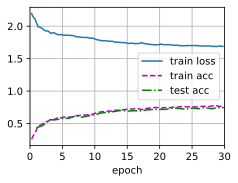

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') #choose device: cpu or gpu
print('Using device:', device)
if torch.cuda.is_available(): print(torch.cuda.get_device_name(0)) # print the type of the chosen gpu
num_epochs=30
trainf(net, train_iter, test_iter, loss, num_epochs, optimizer, device)

loss 1.615, train acc 0.846, test acc 0.816
0.3 examples/sec on cuda
[(1, 0.4342), (2, 0.4699), (3, 0.5567), (4, 0.5589), (5, 0.5777), (6, 0.5818), (7, 0.6167), (8, 0.5975), (9, 0.6174), (10, 0.6344), (11, 0.663), (12, 0.6727), (13, 0.6855), (14, 0.7013), (15, 0.6909), (16, 0.6974), (17, 0.6935), (18, 0.7098), (19, 0.7179), (20, 0.7169), (21, 0.719), (22, 0.737), (23, 0.7321), (24, 0.7211), (25, 0.7378), (26, 0.7286), (27, 0.7463), (28, 0.7277), (29, 0.7451), (30, 0.7454), (1, 0.7436), (2, 0.7374), (3, 0.7412), (4, 0.7595), (5, 0.7535), (6, 0.7458), (7, 0.7596), (8, 0.7564), (9, 0.7669), (10, 0.7703), (11, 0.7691), (12, 0.7679), (13, 0.7577), (14, 0.7636), (15, 0.7633), (16, 0.7585), (17, 0.7763), (18, 0.7601), (19, 0.7493), (20, 0.7604), (21, 0.7871), (22, 0.7751), (23, 0.7699), (24, 0.7777), (25, 0.7872), (26, 0.7885), (27, 0.7792), (28, 0.783), (29, 0.7796), (30, 0.7921), (31, 0.7732), (32, 0.7843), (33, 0.7906), (34, 0.7803), (35, 0.7793), (36, 0.7839), (37, 0.7879), (38, 0.7892), 

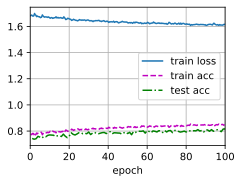

In [ ]:
num_epochs=100
trainf(net, train_iter, test_iter, loss, num_epochs, optimizer, device)

loss 1.586, train acc 0.875, test acc 0.821
0.3 examples/sec on cuda
[(1, 0.4342), (2, 0.4699), (3, 0.5567), (4, 0.5589), (5, 0.5777), (6, 0.5818), (7, 0.6167), (8, 0.5975), (9, 0.6174), (10, 0.6344), (11, 0.663), (12, 0.6727), (13, 0.6855), (14, 0.7013), (15, 0.6909), (16, 0.6974), (17, 0.6935), (18, 0.7098), (19, 0.7179), (20, 0.7169), (21, 0.719), (22, 0.737), (23, 0.7321), (24, 0.7211), (25, 0.7378), (26, 0.7286), (27, 0.7463), (28, 0.7277), (29, 0.7451), (30, 0.7454), (1, 0.7436), (2, 0.7374), (3, 0.7412), (4, 0.7595), (5, 0.7535), (6, 0.7458), (7, 0.7596), (8, 0.7564), (9, 0.7669), (10, 0.7703), (11, 0.7691), (12, 0.7679), (13, 0.7577), (14, 0.7636), (15, 0.7633), (16, 0.7585), (17, 0.7763), (18, 0.7601), (19, 0.7493), (20, 0.7604), (21, 0.7871), (22, 0.7751), (23, 0.7699), (24, 0.7777), (25, 0.7872), (26, 0.7885), (27, 0.7792), (28, 0.783), (29, 0.7796), (30, 0.7921), (31, 0.7732), (32, 0.7843), (33, 0.7906), (34, 0.7803), (35, 0.7793), (36, 0.7839), (37, 0.7879), (38, 0.7892), 

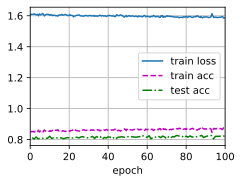

In [ ]:
num_epochs=100
trainf(net, train_iter, test_iter, loss, num_epochs, optimizer, device)

loss 1.579, train acc 0.881, test acc 0.817
0.4 examples/sec on cuda
[(1, 0.4342), (2, 0.4699), (3, 0.5567), (4, 0.5589), (5, 0.5777), (6, 0.5818), (7, 0.6167), (8, 0.5975), (9, 0.6174), (10, 0.6344), (11, 0.663), (12, 0.6727), (13, 0.6855), (14, 0.7013), (15, 0.6909), (16, 0.6974), (17, 0.6935), (18, 0.7098), (19, 0.7179), (20, 0.7169), (21, 0.719), (22, 0.737), (23, 0.7321), (24, 0.7211), (25, 0.7378), (26, 0.7286), (27, 0.7463), (28, 0.7277), (29, 0.7451), (30, 0.7454), (1, 0.7436), (2, 0.7374), (3, 0.7412), (4, 0.7595), (5, 0.7535), (6, 0.7458), (7, 0.7596), (8, 0.7564), (9, 0.7669), (10, 0.7703), (11, 0.7691), (12, 0.7679), (13, 0.7577), (14, 0.7636), (15, 0.7633), (16, 0.7585), (17, 0.7763), (18, 0.7601), (19, 0.7493), (20, 0.7604), (21, 0.7871), (22, 0.7751), (23, 0.7699), (24, 0.7777), (25, 0.7872), (26, 0.7885), (27, 0.7792), (28, 0.783), (29, 0.7796), (30, 0.7921), (31, 0.7732), (32, 0.7843), (33, 0.7906), (34, 0.7803), (35, 0.7793), (36, 0.7839), (37, 0.7879), (38, 0.7892), 

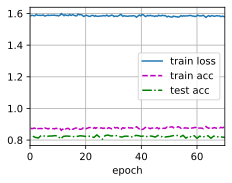

In [ ]:
num_epochs=70
trainf(net, train_iter, test_iter, loss, num_epochs, optimizer, device)

loss 1.581, train acc 0.880, test acc 0.825
15.8 examples/sec on cuda
[(1, 0.4342), (2, 0.4699), (3, 0.5567), (4, 0.5589), (5, 0.5777), (6, 0.5818), (7, 0.6167), (8, 0.5975), (9, 0.6174), (10, 0.6344), (11, 0.663), (12, 0.6727), (13, 0.6855), (14, 0.7013), (15, 0.6909), (16, 0.6974), (17, 0.6935), (18, 0.7098), (19, 0.7179), (20, 0.7169), (21, 0.719), (22, 0.737), (23, 0.7321), (24, 0.7211), (25, 0.7378), (26, 0.7286), (27, 0.7463), (28, 0.7277), (29, 0.7451), (30, 0.7454), (1, 0.7436), (2, 0.7374), (3, 0.7412), (4, 0.7595), (5, 0.7535), (6, 0.7458), (7, 0.7596), (8, 0.7564), (9, 0.7669), (10, 0.7703), (11, 0.7691), (12, 0.7679), (13, 0.7577), (14, 0.7636), (15, 0.7633), (16, 0.7585), (17, 0.7763), (18, 0.7601), (19, 0.7493), (20, 0.7604), (21, 0.7871), (22, 0.7751), (23, 0.7699), (24, 0.7777), (25, 0.7872), (26, 0.7885), (27, 0.7792), (28, 0.783), (29, 0.7796), (30, 0.7921), (31, 0.7732), (32, 0.7843), (33, 0.7906), (34, 0.7803), (35, 0.7793), (36, 0.7839), (37, 0.7879), (38, 0.7892),

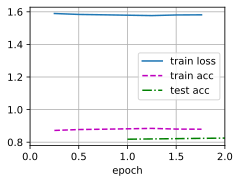

In [ ]:
num_epochs=2
trainf(net, train_iter, test_iter, loss, num_epochs, optimizer, device)

# **5.Final model accuracy on CIFAR-10 Validation Set**

In [ ]:
test_acc = mu.evaluate_accuracy_gpu(net, test_iter)
test_acc

0.8258

In [ ]:
print(epochaccuracy['test_acc'])

[(1, 0.4342), (2, 0.4699), (3, 0.5567), (4, 0.5589), (5, 0.5777), (6, 0.5818), (7, 0.6167), (8, 0.5975), (9, 0.6174), (10, 0.6344), (11, 0.663), (12, 0.6727), (13, 0.6855), (14, 0.7013), (15, 0.6909), (16, 0.6974), (17, 0.6935), (18, 0.7098), (19, 0.7179), (20, 0.7169), (21, 0.719), (22, 0.737), (23, 0.7321), (24, 0.7211), (25, 0.7378), (26, 0.7286), (27, 0.7463), (28, 0.7277), (29, 0.7451), (30, 0.7454), (1, 0.7436), (2, 0.7374), (3, 0.7412), (4, 0.7595), (5, 0.7535), (6, 0.7458), (7, 0.7596), (8, 0.7564), (9, 0.7669), (10, 0.7703), (11, 0.7691), (12, 0.7679), (13, 0.7577), (14, 0.7636), (15, 0.7633), (16, 0.7585), (17, 0.7763), (18, 0.7601), (19, 0.7493), (20, 0.7604), (21, 0.7871), (22, 0.7751), (23, 0.7699), (24, 0.7777), (25, 0.7872), (26, 0.7885), (27, 0.7792), (28, 0.783), (29, 0.7796), (30, 0.7921), (31, 0.7732), (32, 0.7843), (33, 0.7906), (34, 0.7803), (35, 0.7793), (36, 0.7839), (37, 0.7879), (38, 0.7892), (39, 0.7807), (40, 0.7876), (41, 0.795), (42, 0.7786), (43, 0.7868), 

In [ ]:
epo=[]
accu=[]
for a in epochaccuracy['test_acc']:
    epo.append(a[0])
    accu.append(a[1])
len(epo),len(accu)

(302, 302)

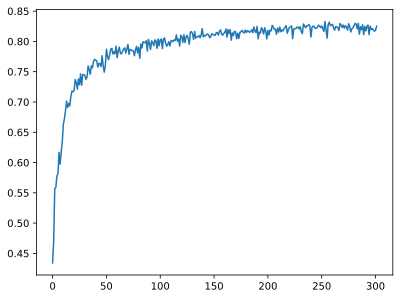

In [ ]:
import matplotlib.pyplot as plt
plt.plot(accu)
plt.show()